In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/

/content/drive


In [ ]:
ls

MyDrive/


In [ ]:
cd MyDrive

/content/drive/MyDrive


In [ ]:
cd cgcnn_hoip

/content/drive/MyDrive/cgcnn_hoip


In [ ]:
!pip3 install pymatgen

In [ ]:
from random import sample
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.autograd import Variable
from torch.utils.data import DataLoader
from cgcnn_update.data import CIFData
from cgcnn_update.data import collate_pool, get_train_val_test_loader
from cgcnn_update.model import CrystalGraphConvNet
gpu_boole = torch.cuda.is_available()

In [ ]:
# The code for the Normalizer and AverageMeter class was taken from the
# original CGCNN repoistory
# The dataset and model was also taken from the original model and modified
# to account for the different loss function implemented in this work

In [ ]:
bracket = np.arange(-0.05, 10.05, 0.1)
bracket[0] = 0
bracket = torch.from_numpy(bracket)
if gpu_boole:
    bracket = bracket.cuda()

dataset = CIFData('cif_merge', bracket=0.1)
train_loader, val_loader, test_loader = get_train_val_test_loader(dataset=dataset,
                                                                  collate_fn=collate_pool,
                                                                  batch_size=12, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                                                                  pin_memory=gpu_boole, return_test=True,
                                                                  train_size=None, test_size=None, val_size=None)
structures, target, _ = dataset[0]
orig_atom_fea_len = structures[0].shape[-1]
nbr_fea_len = structures[1].shape[-1]
print(target)

(2.3074, 24)


/usr/local/lib/python3.6/dist-packages/pymatgen/io/cif.py:745: UserWarning:

No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.

/usr/local/lib/python3.6/dist-packages/pymatgen/io/cif.py:1194: UserWarning:

Issues encountered while parsing CIF: No _symmetry_equiv_pos_as_xyz type key found. Spacegroup from _symmetry_space_group_name_H-M used.



In [ ]:
# model_checkpoint = torch.load('band-gap.pth.tar')
# model_args = model_checkpoint['args']
# print(model_args['atom_fea_len'])
# print(model_args['n_conv'])
# print(model_args['h_fea_len'])
# print(model_args['n_h'])

64
4
32
1


In [ ]:
model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len,
                            atom_fea_len=64,
                            n_conv=4, h_fea_len=32, n_h=1,
                            classification=False, bracket=101)
if gpu_boole:
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def mae(prediction, target):
    """
    Computes the mean absolute error between prediction and target
    Parameters
    ----------
    prediction: torch.Tensor (N, 1)
    target: torch.Tensor (N, 1)
    """
    return torch.mean(torch.abs(target - prediction))

def rmse(prediction, target):
    """
    Computes the root mean square error between prediction and target
    Parameters
    ----------
    prediction: torch.Tensor(N, 1)
    target: torch.Tensor(N, 1)
    """

    return torch.sqrt(torch.mean(torch.square(target - prediction)))

In [ ]:
def predict_value(value):
    _, pred = torch.max(value, dim=1)
    batch_size = pred.shape[0]
    value_tensor = bracket.expand(batch_size, -1)
    values = value_tensor.gather(1, pred.unsqueeze(1))
    return values

In [ ]:
def train_eval():
    model.train()
    loss_meter = AverageMeter()
    error_meter = AverageMeter()
    with torch.no_grad():
        for e, (inp, target, _) in enumerate(train_loader):
            if gpu_boole:
                inp_var = (inp[0].cuda(),
                            inp[1].cuda(),
                            inp[2].cuda(),
                            [crys_idx.cuda() for crys_idx in inp[3]])
                y_tensor = target[1].cuda()
                y_val = target[0].unsqueeze(1).cuda()
            else:
                inp_var = inp
                y_val = target[0].unsqueeze(1)
        output = model(*inp_var)
        loss = criterion(output, y_tensor)
        loss_meter.update(loss.data.cpu(), y_val.shape[0])
        predictions = predict_value(output)
        error = mae(predictions.cpu(), y_val.cpu())
        error_meter.update(error, y_val.shape[0])

    return loss_meter, error_meter

def val_eval():
    model.eval()
    loss_meter = AverageMeter()
    error_meter = AverageMeter()
    with torch.no_grad():
        for e, (inp, target, _) in enumerate(val_loader):
            if gpu_boole:
                inp_var = (inp[0].cuda(),
                            inp[1].cuda(),
                            inp[2].cuda(),
                            [crys_idx.cuda() for crys_idx in inp[3]])
                y_tensor = target[1].cuda()
                y_val = target[0].unsqueeze(1).cuda()
            else:
                inp_var = inp
                y_val = target[0].unsqueeze(1)
        output = model(*inp_var)
        loss = criterion(output, y_tensor)
        loss_meter.update(loss.data.cpu(), y_val.shape[0])
        predictions = predict_value(output)
        error = mae(predictions.cpu(), y_val.cpu())
        error_meter.update(error, y_val.shape[0])

    return loss_meter, error_meter

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

epochs=100
batch_loss = []
results = []
best_train_error = 1e5
best_val_error = 1e5
n_epochs_per_eval = 10

model.apply(weights_init)

for e in range(epochs):
    warnings.filterwarnings("ignore")
    train_loss = []
    for i, (inp, target, _) in enumerate(train_loader):
        model.train()
        if gpu_boole:
            inp_var = (inp[0].cuda(),
                       inp[1].cuda(),
                       inp[2].cuda(),
                       [crys_idx.cuda() for crys_idx in inp[3]])
            y_tensor = target[1].cuda()
        else:
            inp_var = inp
        y_val = target[0]
        output = model(*inp_var)
        loss = criterion(output, y_tensor)
        batch_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (e + 1) % n_epochs_per_eval == 0:
        train_loss, train_error = train_eval()
        val_loss, val_error = val_eval()
        if train_error.avg < best_train_error:
            best_train_error = train_error.avg
            print('Step {:5d}: best train error {:.3f}'.format((e + 1), best_train_error))
        if val_error.avg < best_val_error:
            best_val_error = val_error.avg
            print('Step {:5d}: best val error {:.3f}'.format((e + 1), best_val_error))
        results.append([(e + 1), train_loss.avg, train_error.avg, val_loss.avg, val_error.avg])

Step    10: best train error 0.238
Step    10: best val error 0.586
Step    20: best train error 0.022
Step    20: best val error 0.344
Step    40: best val error 0.259
Step    50: best val error 0.252


Text(0, 0.5, 'Error')

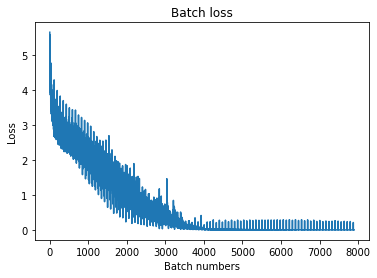

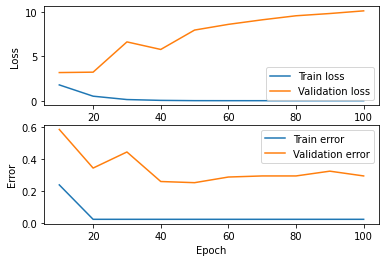

In [ ]:
from matplotlib import pyplot as plt

plt.figure(0)
plt.plot(batch_loss)
plt.title('Batch loss')
plt.xlabel('Batch numbers')
plt.ylabel('Loss')

plt.figure(1)
epoch, train_loss, train_error, val_loss, val_error = zip(*results)
plt.subplot(2,1,1)
plt.plot(epoch, train_loss, epoch, val_loss)
plt.legend(['Train loss', 'Validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(epoch, train_error, epoch, val_error)
plt.legend(['Train error', 'Validation error'])
plt.xlabel('Epoch')
plt.ylabel('Error')

In [ ]:
model.eval()
mae_vals = []
rmse_vals = []
for inp, target, _ in test_loader:
    if gpu_boole:
        inp_var = (inp[0].cuda(),
                    inp[1].cuda(),
                    inp[2].cuda(),
                    [crys_idx.cuda() for crys_idx in inp[3]])
        y_tensor = target[1].cuda()
        y_val = target[0].unsqueeze(1).cuda()
    else:
        inp_var = inp
        y_val = target[0].unsqueeze(1)
    # print(y_val)
    with torch.no_grad():
        output = model(*inp_var)
    temp = predict_value(output)
    mae_vals.append(mae(temp, y_val))
    rmse_vals.append(rmse(temp, y_val))

In [ ]:
print(torch.mean(torch.stack(mae_vals)))
print(torch.mean(torch.stack(rmse_vals)))

tensor(0.3146, device='cuda:0', dtype=torch.float64)
tensor(0.4316, device='cuda:0', dtype=torch.float64)


In [ ]:
# torch.save({'model_state_dict': model.state_dict()},
#            '/content/drive/MyDrive/cgcnn_hoip/cross_entropy_model_chkpt')